This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We are interested in understanding the changes in the synovium due to Tocilizumab treatment. 
This notebook is the QC analysis for the bulk data from Rivellese, F. et al. Rituximab versus tocilizumab in rheumatoid arthritis: synovial biopsy-based biomarker analysis of the phase 4 R4RA randomized trial. Nat. Med. 28, 1256–1268 (2022).

This will be used with single-cell untreated synovium data from Zhang, F. et al. Deconstruction of rheumatoid arthritis synovium defines inflammatory subtypes. Nature 623, 616–624 (2023).
DOI:10.1038/s41586-023-06708-y, to infer the cell-type specific treatment effects.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.23.5 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.3.1 statsmodels==0.14.0 python-igraph==0.10.8 pynndescent==0.5.10


## Open files

In [2]:
data_path = f"{os.getcwd()}/../../data/bulk_data/synovium/"

#curr_treatment = "Rituximab"
curr_treatment = "Tocilizumab"
# file downloaded from SeuratData then converted to h5ad 



in_file = f"{data_path}/synovium_bulk.h5ad"
results_file = f"{data_path}/synovium_bulk_processed_{curr_treatment}.h5ad"

with open(in_file) as your_data:
    adata = sc.read_h5ad(in_file)

adata


AnnData object with n_obs × n_vars = 184 × 24569
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pred_CTAP', 'sample_name', 'ena_sample', 'biosd_sample', 'sample_id', 'organism', 'individual', 'tissue_part', 'disease', 'clinical_history', 'age', 'unit_time', 'term_source_ref', 'term_accession_number', 'sex', 'ethnic_group', 'visit', 'unit_time_1', 'term_source_ref_1', 'term_accession_number_1', 'rheumatoid_factor_measurement', 'ccp_measurement', 'tender_joints_count', 'unit_count_unit', 'term_source_ref_2', 'term_accession_number_2', 'swollen_joints_count', 'unit_count_unit_1', 'term_source_ref_3', 'term_accession_number_3', 'arthritis_disease_activity_score', 'esr', 'unit_length_unit', 'term_source_ref_4', 'term_accession_number_4', 'crp', 'unit_concentration_unit', 'term_source_ref_5', 'term_accession_number_5', 'physician_global_assessment', 'cdai_response_status', 'bcell_class', 'pathotype', 'imputed_log_crp1', 'imputed_log_esr', 'imputed_tj_sqrt', 'imputed_sj_sqrt', 'imputed

In [3]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

# remove non-gene IDs
gene_idx = np.where(np.logical_not(adata.var_names.str.startswith('__')))[0]
adata = adata[:, gene_idx]



In [4]:
adata.var_names[np.where(adata.var_names.str.startswith('__'))]

Index([], dtype='object')

In [5]:
# how many of each mouse
tab = adata.obs.groupby(['sampling_time_point', 'sex']).size()

tab.unstack()

sex,female,male
sampling_time_point,,
0,109,24
16,43,8


In [6]:
# how many of each mouse
tab = adata.obs.groupby(['sampling_time_point', 'treatment']).size()

tab.unstack()

treatment,Rituximab,Tocilizumab
sampling_time_point,,
0,68,65
16,33,18


In [7]:
# how many of each mouse
tab = adata[np.where(adata.obs.treatment == "Tocilizumab")[0]].obs.groupby(['sampling_time_point', 'cdai_response_status']).size()

tab.unstack()

cdai_response_status,Non.Responder,Responder
sampling_time_point,,
0,28,37
16,12,6


In [8]:
# how many of each mouse
tab = adata[np.where(adata.obs.treatment == "Rituximab")[0]].obs.groupby(['sampling_time_point', 'cdai_response_status']).size()

tab.unstack()

cdai_response_status,Non.Responder,Responder
sampling_time_point,,
0,39,29
16,21,12


In [9]:

# subset to treatments and responders
adata = adata[np.where(adata.obs["treatment"] == curr_treatment)]

# format sample name
adata.obs['sample_id'] = adata.obs.index.str[:12]


adata.obs

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_81061/765138109.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample_id'] = adata.obs.index.str[:12]


,orig.ident,nCount_RNA,nFeature_RNA,pred_CTAP,sample_name,ena_sample,biosd_sample,sample_id,organism,individual,...,ena_run,fastq_url,sampling_time_point,unit_time_unit_2,term_source_ref_6,term_accession_number_6,entropy,CV1,CV2,treatment
R4RAPAT00002-week0,0,33092230.0,22623,0,Sample 1,ERS11589556,SAMEA13989176,R4RAPAT00002,Homo sapiens,R4RAPAT00002,...,ERR9539213,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/003/...,0,week,EFO,UO_0000034,0.950271,0.337867,-0.181978,Tocilizumab
R4RAPAT00095-week0,0,17119043.0,23105,5,Sample 101,ERS11589559,SAMEA13989179,R4RAPAT00095,Homo sapiens,R4RAPAT00095,...,ERR9539216,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/006/...,0,week,EFO,UO_0000034,0.500402,0.564162,0.061935,Tocilizumab
R4RAPAT00096-week0,0,14005488.0,23042,0,Sample 102,ERS11589560,SAMEA13989180,R4RAPAT00096,Homo sapiens,R4RAPAT00096,...,ERR9539217,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/007/...,0,week,EFO,UO_0000034,0.950271,0.151749,-0.133618,Tocilizumab
R4RAPAT00099-week0,0,17990086.0,22917,0,Sample 105,ERS11589563,SAMEA13989183,R4RAPAT00099,Homo sapiens,R4RAPAT00099,...,ERR9539220,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/000/...,0,week,EFO,UO_0000034,0.950271,0.012810,-0.208987,Tocilizumab
R4RAPAT00099-week16,0,26034805.0,22994,5,Sample 106,ERS11589564,SAMEA13989184,R4RAPAT00099,Homo sapiens,R4RAPAT00099,...,ERR9539221,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/001/...,16,week,EFO,UO_0000034,-0.000000,0.443172,0.319264,Tocilizumab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R4RAPAT00082-week0,0,15713485.0,21955,0,Sample 88,ERS11589729,SAMEA13989349,R4RAPAT00082,Homo sapiens,R4RAPAT00082,...,ERR9539384,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/004/...,0,week,EFO,UO_0000034,1.332179,0.109092,-0.039501,Tocilizumab
R4RAPAT00083-week0,0,28457267.0,22458,2,Sample 89,ERS11589730,SAMEA13989350,R4RAPAT00083,Homo sapiens,R4RAPAT00083,...,ERR9539385,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/005/...,0,week,EFO,UO_0000034,-0.000000,-0.135791,0.132298,Tocilizumab
R4RAPAT00084-week0,0,27494642.0,22671,5,Sample 90,ERS11589732,SAMEA13989352,R4RAPAT00084,Homo sapiens,R4RAPAT00084,...,ERR9539387,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/007/...,0,week,EFO,UO_0000034,1.054920,0.523723,-0.001788,Tocilizumab
R4RAPAT00090-week0,0,27819718.0,21531,2,Sample 93,ERS11589735,SAMEA13989355,R4RAPAT00090,Homo sapiens,R4RAPAT00090,...,ERR9539390,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/000/...,0,week,EFO,UO_0000034,-0.000000,-0.396250,0.439701,Tocilizumab


In [10]:
# how many of each mouse
tab = adata.obs.groupby(['sample_id', 'bcell_class']).size()

tab.unstack()



bcell_class,Bpoor,Brich,GC
sample_id,,,
R4RAPAT00002,1.0,NaN,NaN
R4RAPAT00004,1.0,NaN,NaN
R4RAPAT00005,NaN,1.0,NaN
R4RAPAT00007,1.0,NaN,NaN
R4RAPAT00014,1.0,NaN,NaN
...,...,...,...
R4RAPAT00148,NaN,1.0,NaN
R4RAPAT00150,NaN,NaN,1.0
R4RAPAT00152,NaN,1.0,NaN


In [11]:
# how many of each mouse
tab = adata.obs.groupby(['cdai_response_status', 'sampling_time_point']).size()

tab.unstack()

sampling_time_point,0,16
cdai_response_status,,
Non.Responder,28,12
Responder,37,6


In [12]:


# how many of each mouse
tab = adata.obs.groupby(['sample_id', 'sampling_time_point']).size()
tab.unstack()

sampling_time_point,0,16
sample_id,,
R4RAPAT00002,1.0,NaN
R4RAPAT00004,1.0,NaN
R4RAPAT00005,1.0,NaN
R4RAPAT00007,1.0,NaN
R4RAPAT00014,1.0,NaN
...,...,...
R4RAPAT00148,1.0,NaN
R4RAPAT00150,1.0,NaN
R4RAPAT00152,1.0,NaN


## format the obs for BuDDI

In [13]:

# Initialize empty column in cell metadata
# for stim vs ctrl


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "0":
        out_str = "CTRL"
           
    return(out_str)

adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs["sampling_time_point"].tolist()]
adata.var['gene_ids'] = adata.var.index.tolist()


In [14]:
# how many of each 
tab = adata.obs.groupby(['sample_id', 'stim']).size()
tab.unstack()

stim,CTRL,STIM
sample_id,,
R4RAPAT00002,1.0,NaN
R4RAPAT00004,1.0,NaN
R4RAPAT00005,1.0,NaN
R4RAPAT00007,1.0,NaN
R4RAPAT00014,1.0,NaN
...,...,...
R4RAPAT00148,1.0,NaN
R4RAPAT00150,1.0,NaN
R4RAPAT00152,1.0,NaN


In [15]:
# get samples with paired before and after
tab = adata.obs.groupby(['sample_id', 'stim']).size()
temp_tab = tab.unstack()
paired_samps = np.asarray(temp_tab.index[np.where(np.sum(np.asarray(tab.unstack()), axis=1) == 2)[0]])

adata = adata[adata.obs["sample_id"].isin(paired_samps)]
tab = adata.obs.groupby(['sample_id', 'stim']).size()
tab.unstack()

stim,CTRL,STIM
sample_id,,
R4RAPAT00027,1,1
R4RAPAT00047,1,1
R4RAPAT00056,1,1
R4RAPAT00060,1,1
R4RAPAT00066,1,1
R4RAPAT00072,1,1
R4RAPAT00099,1,1
R4RAPAT00107,1,1
R4RAPAT00110,1,1


In [16]:
paired_samps

array(['R4RAPAT00027', 'R4RAPAT00047', 'R4RAPAT00056', 'R4RAPAT00060',
       'R4RAPAT00066', 'R4RAPAT00072', 'R4RAPAT00099', 'R4RAPAT00107',
       'R4RAPAT00110', 'R4RAPAT00114', 'R4RAPAT00117', 'R4RAPAT00118',
       'R4RAPAT00129', 'R4RAPAT00140', 'R4RAPAT00142', 'R4RAPAT00145'],
      dtype=object)

In [17]:

tab = adata.obs.groupby(['sample_id', 'cdai_response_status']).size()
tab.unstack()

cdai_response_status,Non.Responder,Responder
sample_id,,
R4RAPAT00027,NaN,2.0
R4RAPAT00047,NaN,2.0
R4RAPAT00056,2.0,NaN
R4RAPAT00060,NaN,2.0
R4RAPAT00066,2.0,NaN
R4RAPAT00072,2.0,NaN
R4RAPAT00099,2.0,NaN
R4RAPAT00107,2.0,NaN
R4RAPAT00110,NaN,2.0


## Preprocessing

normalizing counts per cell
    finished (0:00:00)


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


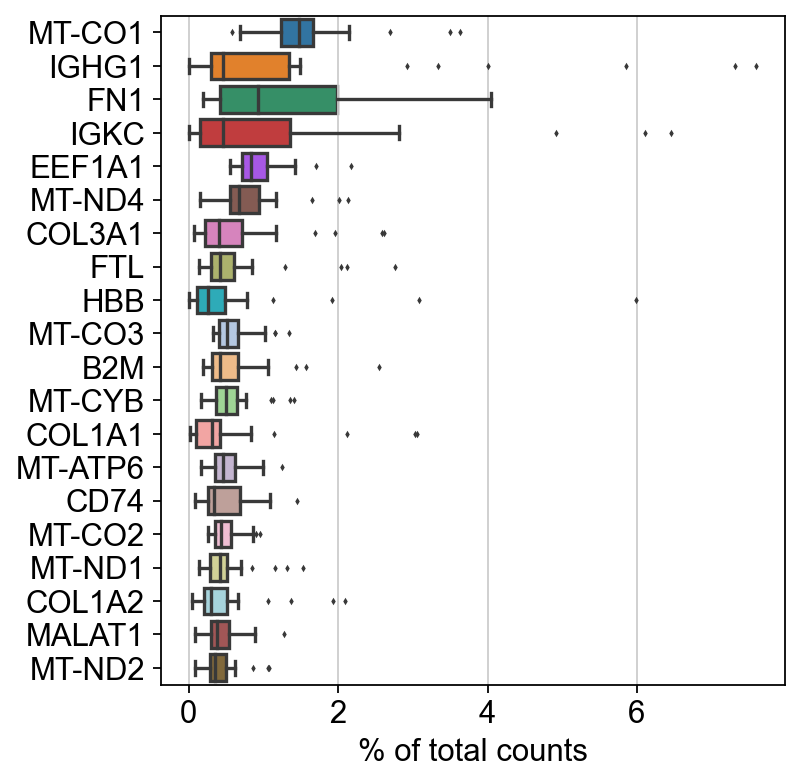

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20, )


# Write + Plot data

In [19]:
results_file

'/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/sc_preprocessing/0_qc_notebooks/../../data/bulk_data/synovium//synovium_bulk_processed_Tocilizumab.h5ad'

In [20]:
# write it out before normalization
del adata.raw
adata.write(results_file)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


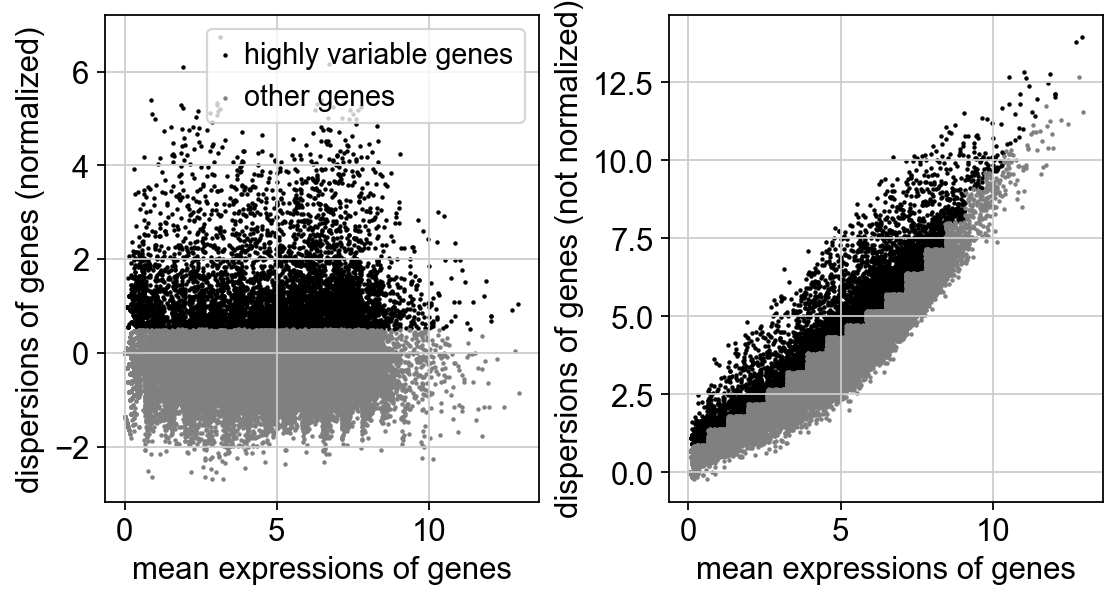

In [21]:

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=15, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)



In [22]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=20)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## PCA

In [23]:
sc.tl.pca(adata, n_comps=20)
sc.pp.neighbors(adata)


computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


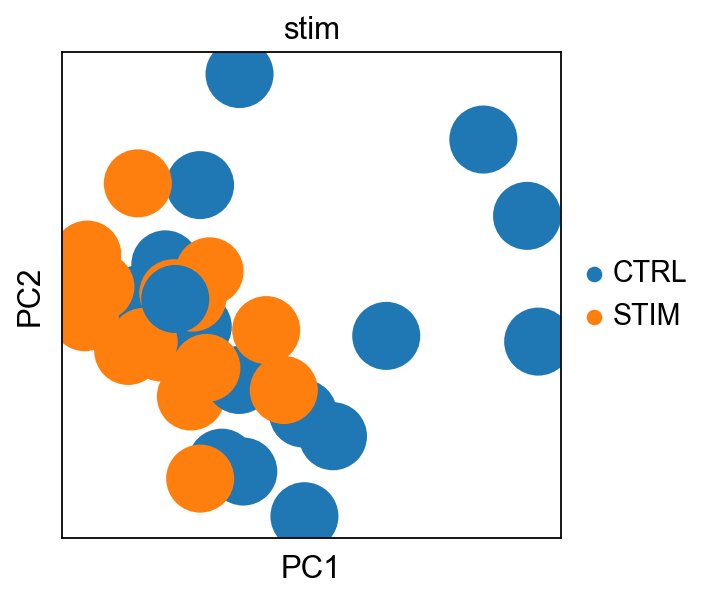

In [24]:
sc.pl.pca(adata, color="stim")

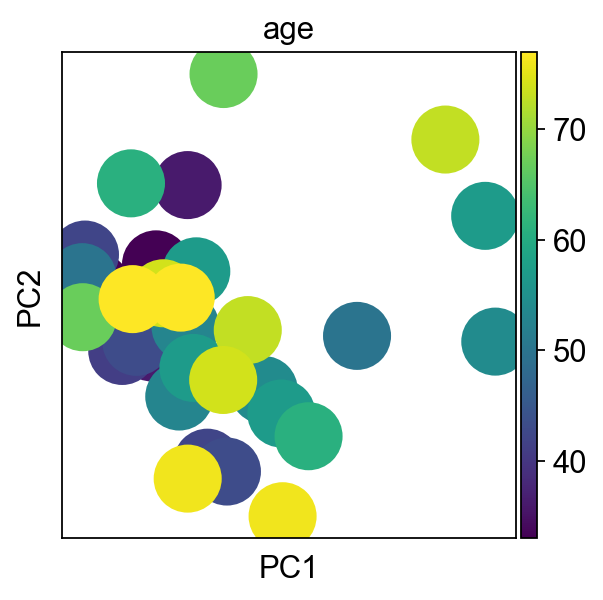

In [25]:
sc.pl.pca(adata, color="age")

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


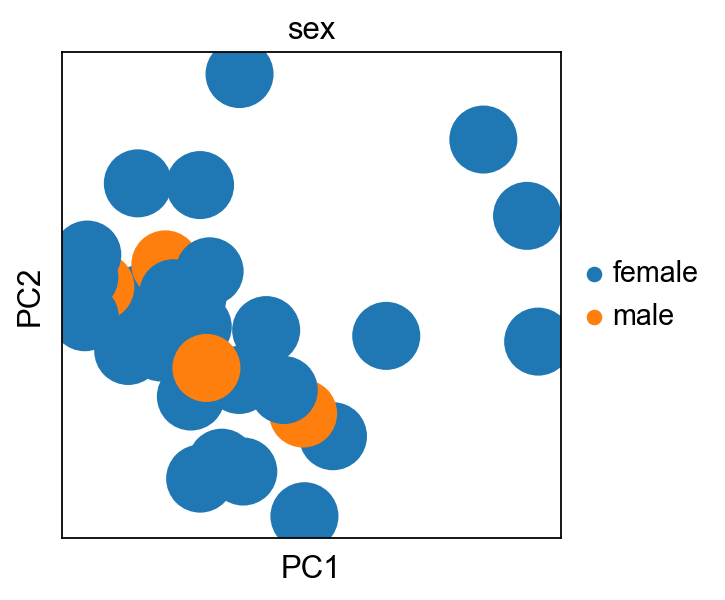

In [26]:
sc.pl.pca(adata, color="sex")

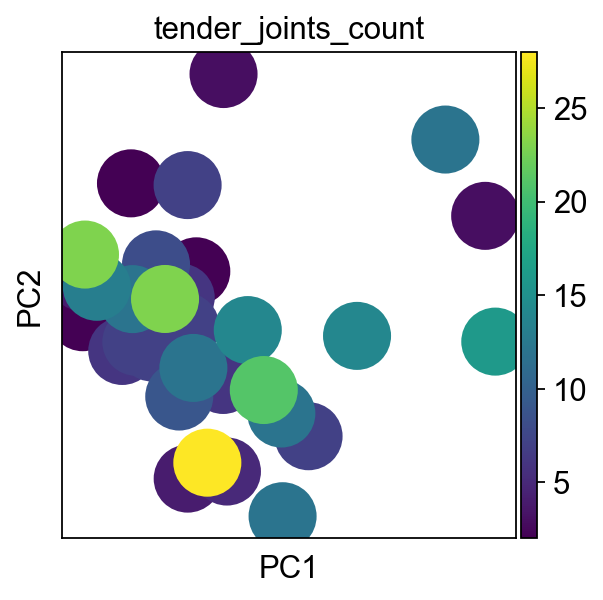

In [27]:
sc.pl.pca(adata, color="tender_joints_count")

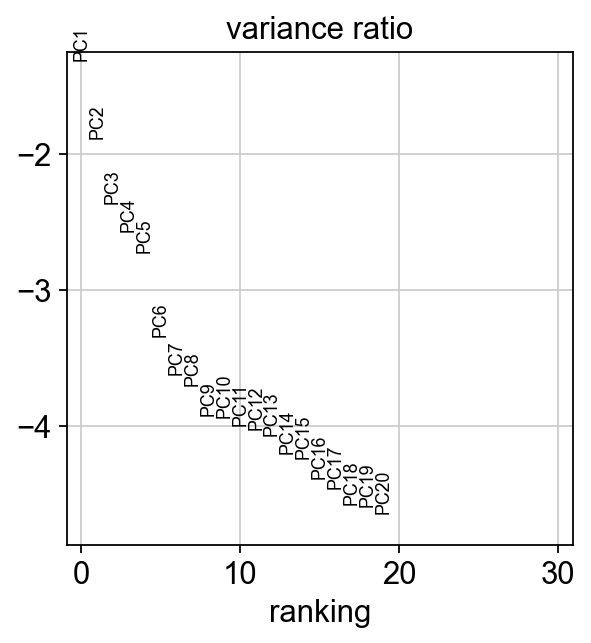

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)



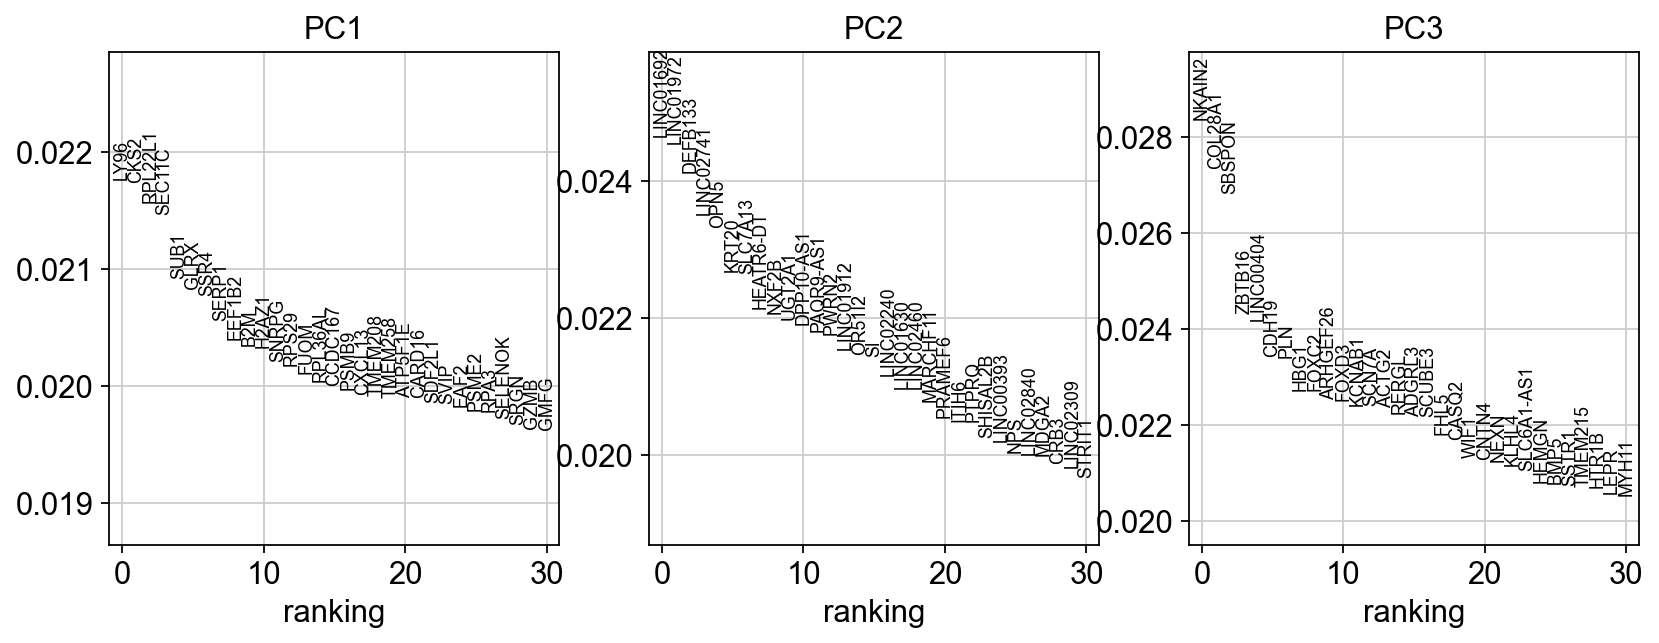

In [29]:
sc.pl.pca_loadings(adata, include_lowest=False)
